In [1]:
# Import library
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import VAR
!pip install vnstock
from vnstock import *

In [2]:
# Import data
VND = stock_historical_data(symbol = "VND", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(VND['Close']))
VND
#VND["Close"].plot()

Observations:  1630


,Open,High,Low,Close,Volume,Ticker
Time,,,,,,
2017-06-01,3200,3250,3200,3230,167483,VND
2017-06-02,3230,3330,3200,3280,411631,VND
2017-06-05,3320,3370,3270,3280,671582,VND
2017-06-06,3280,3320,3270,3320,174560,VND
2017-06-07,3320,3610,3320,3590,2332950,VND
...,...,...,...,...,...,...
2023-12-11,21700,22050,21400,21950,24142900,VND
2023-12-12,22000,22300,22000,22050,16260700,VND
2023-12-13,22250,22350,21500,21600,21677300,VND


In [3]:
# Preprocessing
scaler = MinMaxScaler(feature_range=(0,1))
def preprocessing(data):
    df = data[["Close", "Volume"]]
    df = df.reset_index(drop = True)
    df['Close'] = scaler.fit_transform(np.array(df['Close']).reshape(-1,1))
    df['Volume'] = scaler.transform(np.array(df['Volume']).reshape(-1,1))
    print(df)
    return df

def SplitSet73(data):
    train_size = int(0.7*len(data))
    test_size = int(0.3*len(data))
    train_data = data[:train_size]
    test_data = data[train_size:]
    print("Train data:\n", train_data.shape)
    print("Test data: \n", test_data.shape)
    return train_size, test_size, train_data, test_data
    

In [4]:
df = preprocessing(VND)

         Close       Volume
0     0.021705     5.114822
1     0.023256    12.685302
2     0.023256    20.745798
3     0.024496     5.334264
4     0.032868    72.261085
...        ...          ...
1625  0.602171   748.538605
1626  0.605271   504.129302
1627  0.591318   672.085891
1628  0.586667   554.730853
1629  0.597519  1177.924651

[1630 rows x 2 columns]


In [5]:
train_size = int(0.6*len(df))
test_size = int(0.4*len(df))
train_data = df[:train_size]
test_data = df[train_size:]
print("Train data:\n", train_data.shape)
print("Test data: \n", test_data.shape)

Train data:
 (978, 2)
Test data: 
 (652, 2)


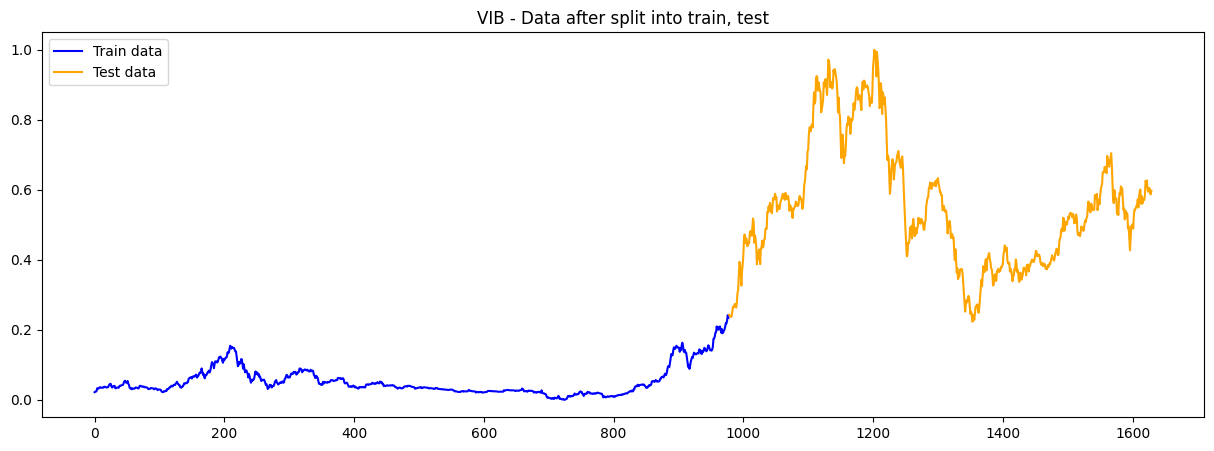

In [6]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Close'], 'b')
plt.plot(test_data.index, test_data['Close'], 'orange')
plt.legend(['Train data', 'Test data'], loc='upper left')
plt.title('VIB - Data after split into train, test')
plt.show()

In [7]:
model_var = VAR(train_data)
for i in range(1,10):
    results = model_var.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  -4.310067273851135
BIC:  -4.28007042644862

Order = 2
AIC:  -4.345052147786323
BIC:  -4.2950166704665165

Order = 3
AIC:  -4.405416592283459
BIC:  -4.335309797828106

Order = 4
AIC:  -4.446945498919842
BIC:  -4.356734612404887

Order = 5
AIC:  -4.458500459867363
BIC:  -4.348152618337977

Order = 6
AIC:  -4.4682897558111145
BIC:  -4.337772007955176

Order = 7
AIC:  -4.471169556091168
BIC:  -4.32044886191121

Order = 8
AIC:  -4.485926587513085
BIC:  -4.314969817996681

Order = 9
AIC:  -4.484567526720793
BIC:  -4.293341463509391



In [8]:
result = model_var.fit(5)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 30, Dec, 2023
Time:                     22:30:20
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.34815
Nobs:                     973.000    HQIC:                  -4.41650
Log likelihood:          -570.194    FPE:                  0.0115797
AIC:                     -4.45850    Det(Omega_mle):       0.0113223
--------------------------------------------------------------------
Results for equation Close
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000188         0.000209            0.901           0.367
L1.Close          1.068054         0.032232           33.137           0.000
L1.Volume         0.000012         0.000005            2.652           0.008

In [9]:
lags_order = result.k_ar
lags_order

5

In [10]:
#Predict the price
y_pred_test = []
for i in range(test_data.shape[0] - lags_order):
    forecast_input = test_data[i:(i+lags_order)].values
    pred = result.forecast(forecast_input, steps=1)
    y_pred_test.append(list(pred[0]))

y_pred_test_price = np.array(scaler.inverse_transform(np.array(y_pred_test).transpose()[0].reshape(-1, 1)))
y_pred_test_vol = np.array(scaler.inverse_transform(np.array(y_pred_test).transpose()[1].reshape(-1, 1)))
y_pred_test_price.shape

(647, 1)

In [11]:
number_of_days_to_predict = 60

In [12]:
ndays_pred = result.forecast(df[-lags_order-number_of_days_to_predict:-number_of_days_to_predict].values, steps=number_of_days_to_predict)
ndays_pred = np.array(ndays_pred)[:, 0]
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))

ndays_pred.shape

(60, 1)

In [13]:
y_test = test_data['Close'].values[lags_order:]
y_test = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
y_test.shape

(647, 1)

In [17]:
def RSME (data1, data2):
    return np.sqrt(np.mean((data1-data2)*(data1-data2)))
def MAE (data1, data2):
    return np.mean(np.absolute(data1-data2))
def MAPE (pred, actual):
    return np.mean(np.absolute((pred-actual)/actual))*100
def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))

print("RSME test :", RSME(y_pred_test_price, y_test))
print("MAE test : ", MAE(y_pred_test_price, y_test))
print("MAPE test: ", MAPE(y_pred_test_price, y_test))
print("MSLR test: ", MSLE(y_pred_test_price, y_test))

RSME test : 758.9806859023804
MAE test :  579.5508681889935
MAPE test:  2.947231388678157
MSLR test:  0.0014411433357184947


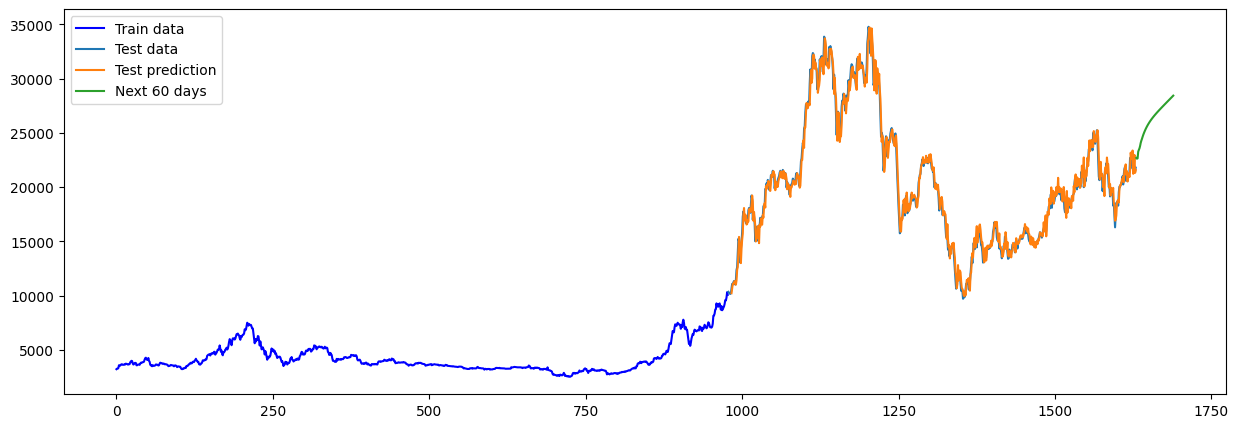

In [15]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, scaler.inverse_transform(np.array(train_data['Close']).reshape(-1, 1)), color="blue")
plt.plot(test_data.index, scaler.inverse_transform(np.array(test_data['Close']).reshape(-1, 1)).reshape(-1, 1))
plt.plot(test_data.index[-len(y_pred_test_price):], y_pred_test_price)
pred_ind = pd.RangeIndex(start = len(df['Close']), stop = len(df['Close'])+60)
plt.plot(pred_ind, ndays_pred)

plt.legend(["Train data", "Test data", "Test prediction", "Next 60 days"])
plt.show()